In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import shutil

from collections import Counter

from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD, IncrementalPCA
from scipy.sparse import csr_matrix, lil_matrix
import scipy
from itertools import chain
import statistics
from sklearn.pipeline import make_pipeline
from sklearn import svm, preprocessing
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from numpy import expand_dims

from tensorflow.keras.utils import to_categorical
from tensorflow import concat
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import tensorflow
import os
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras import applications
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
import keras_tuner as kt
from keras.applications.vgg19 import preprocess_input
from tensorflow.image import rgb_to_grayscale, grayscale_to_rgb
from tensorflow import tile
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
image_size = 224
input_shape = (image_size, image_size, 3)

2022-12-05 11:22:15.437833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-05 11:22:15.437891: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Importation des données

In [6]:
# importation des données

categories = os.listdir('../donnees_nettoyees_models/donnees_nettoyees/')
categories.remove('.ipynb_checkpoints')
drawings = []
labels = list()

for folder in tqdm(categories):
    tmp_repertory = '../donnees_nettoyees_models/donnees_nettoyees/' + folder
    #print(folder)
    for img in os.listdir(tmp_repertory):
        if not img.startswith('.'):
            labels.append(folder)
            img = load_img(tmp_repertory + '/' + img, target_size=(224,224,3))
            img = img_to_array(img)
            img = expand_dims(img,axis=0)
            img = preprocess_input(img)
            img = np.array(img)
            img = np.reshape(img, (224,224,3))
            drawings.append(img)

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


## Preprocess data (create the groups)

In [4]:
def preprocess_data(groupes):
    nb_groupes = len(groupes)

    labels_groupes = {}
    index_groupes = {}

    for groupe in list(groupes.keys()): # pour chaque groupe
        labels_groupes[groupe] = [labels[j] for j,x in enumerate(labels) if x in groupes[groupe]]
        index_groupes[groupe] = [j for j,x in enumerate(labels) if x in groupes[groupe]]

    index_length = [len(index_groupes[groupe]) for groupe in groupes]

    for groupe, nb_dessins in zip(list(groupes.keys()), index_length):
        print(f'{groupe} : {nb_dessins}')

    labels_index = sorted(sum(list(index_groupes.values()), []))

    labels_names = []
    drawings_new = []
    for i in tqdm(labels_index):
        labels_names.append(labels[i])
        drawings_new.append(drawings[i])

    labels_final = [''] * len(labels_names)

    for i in range(len(labels_final)):
        for grp_index in range(len(list(groupes.keys()))):
            if labels_names[i] in list(groupes.values())[grp_index]:
                labels_final[i] = list(groupes.keys())[grp_index]
    return drawings_new, labels_final, labels_names

## Bayesian Optimization

In [4]:
def plot_model_history(model_history, accuracy='accuracy', val_accuracy='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[accuracy])+1),model_history.history[accuracy])
    axs[0].plot(range(1,len(model_history.history[val_accuracy])+1),model_history.history[val_accuracy])
    #axs[0].set_xticks(np.arange(1,len(model_history.history[accuracy])+1),len(model_history.history[accuracy])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.savefig('model_10_classes/curves.png')
    #plt.show()

In [5]:
categories_humains = ['Crèche','PS','MS','GS','CE1','CE2','CM1','CM2','NOV','EXP']
groupes_humains = {cat_humain : [cat_humain] for cat_humain in categories_humains}
drawings_new, labels_final, labels_names = preprocess_data(groupes_humains)
drawings_new = np.reshape(drawings_new,(len(drawings_new),224,224,3))
for label_idx in range(len(labels_final)):
    labels_final[label_idx] = '0' + str(categories_humains.index(labels_final[label_idx])) + labels_final[label_idx]
labels_names = labels_final
le = LabelEncoder()
labels_final = le.fit_transform(labels_final)
X_train, X_val, Y_train, Y_val = train_test_split(drawings_new,labels_final, test_size = 0.2, random_state = 42)

Crèche : 30
PS : 39
MS : 40
GS : 40
CE1 : 43
CE2 : 35
CM1 : 41
CM2 : 44
NOV : 42
EXP : 42


100%|██████████| 396/396 [00:00<00:00, 984555.06it/s]


Trial 50 Complete [00h 14m 38s]
val_loss: 2.045083522796631

Best val_loss So Far: 1.969245195388794
Total elapsed time: 12h 25m 02s
INFO:tensorflow:Oracle triggered exit
{'batch_size': 16, 'pool_value': 'avg', 'dropout': 0.4, 'num_layers': 3, 'BatchNorm': 1, 'units_0': 32, 'lr': 0.1, 'units_1': 512, 'units_2': 32}
Epoch 1/15
10/10 [==============================] - 60s 6s/step - loss: 2.3247 - accuracy: 0.0823 - val_loss: 2.2942 - val_accuracy: 0.1125
Epoch 2/15
10/10 [==============================] - 58s 6s/step - loss: 2.2934 - accuracy: 0.1297 - val_loss: 2.2501 - val_accuracy: 0.0875
Epoch 3/15
10/10 [==============================] - 58s 6s/step - loss: 2.2395 - accuracy: 0.1646 - val_loss: 2.2012 - val_accuracy: 0.1750
Epoch 4/15
10/10 [==============================] - 58s 6s/step - loss: 2.2038 - accuracy: 0.2152 - val_loss: 2.1767 - val_accuracy: 0.1875
Epoch 5/15
10/10 [==============================] - 58s 6s/step - loss: 2.1176 - accuracy: 0.2373 - val_loss: 2.1188 - val_

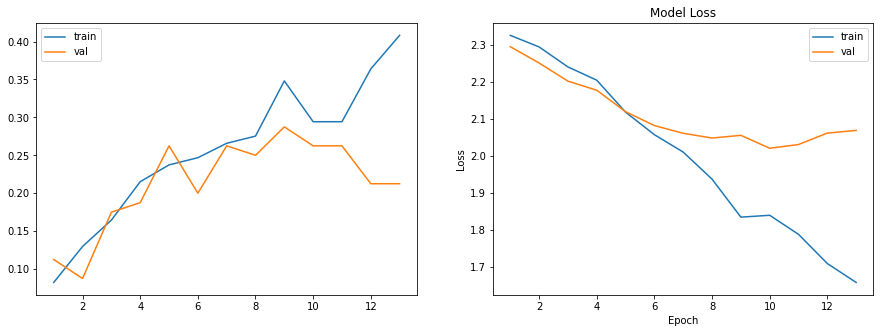

In [6]:
data_augmentation = tf.keras.Sequential(
    [       tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
    ]
)

scores = list()

# optimisation bayésienne
class MyHyperModel(kt.HyperModel):
    def model_builder(self,hp):
        '''
    Args:
    hp - Keras tuner object
        '''
        batch_size = hp.Choice("batch_size", [16, 32, 64])
        # 3 possibilités pour pool à partir de VGG : avg, max, None
        pool_value = hp.Choice('pool_value',values=['avg','max','None'])
        if pool_value == 'None': # si None, il faut le type None
            pool_value = None

        inputs = tf.keras.Input(shape=(224,224,3))
        inputs = data_augmentation(inputs) 
        x = keras.applications.vgg19.VGG19(
        input_tensor=inputs, 
        include_top=False,
        pooling=pool_value,
        weights='imagenet'
        )

        x.trainable = False
        x = Flatten()(x.output)
        hp_dropout = hp.Float('dropout', min_value=0, max_value=0.4, step=0.1)
        x = Dropout(hp_dropout)(x)
        # Tune the number of layers
        nb_layers = hp.Int("num_layers", 1, 3)
        BatchNorm = hp.Choice('BatchNorm',[True,False])
        for num_layer in range(nb_layers):
            # Tune the number of neurons in each layer
            hp_units = hp.Int(f'units_{num_layer}', min_value=32, max_value=512, step=32)  
            x = Dense(hp_units)(x)
            if num_layer==0:
                with hp.conditional_scope("BatchNorm", [True]):
                    if BatchNorm == True:
                        x = BatchNormalization()(x)
            x = Activation('relu')(x)
        outputs = Dense(len(np.unique(Y_train)), activation='softmax')(x)
        model = Model(inputs,outputs)
        learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
        model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate),
              metrics=['accuracy'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=self.batch_size,
            **kwargs,
        )

# Instantiate the tuner
tuner = kt.tuners.BayesianOptimization(
MyHyperModel().model_builder,
objective = 'val_loss',
max_trials = 50, ########################### 50
directory = '',
#        overwrite = True,
project_name = 'model_10_classes')

tuner.search_space_summary()
early_stop_tuner = tf.keras.callbacks.EarlyStopping(
                        monitor = 'val_loss',
                        patience = 15, ############################################## 15
                        restore_best_weights = True)


class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(Y_train),
                                        y = Y_train                                                    
                                    )


class_weight_dict = dict(enumerate(class_weights))
tuner.search(X_train, Y_train, epochs=15, ########################## 15
             validation_data=(X_val, Y_val), verbose=2, callbacks = [early_stop_tuner],
            class_weight = class_weight_dict) 
# Get the top 2 hyperparameters.
#best_hps = tuner.get_best_hyperparameters(5)
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)
# Build the model with the best hp.
best_model = MyHyperModel().model_builder(best_hps)
early_stop = tf.keras.callbacks.EarlyStopping(
                        monitor = 'val_loss',
                        patience = 3, ############################################## 3
                        restore_best_weights = True)

history = best_model.fit(X_train,Y_train, epochs=15, validation_data=(X_val,Y_val), ############################ 15
                callbacks = [early_stop], class_weight = class_weight_dict)
plot_model_history(history)

epoch_val_loss_min = np.argmin(history.history['val_loss'])
val_max = history.history['val_accuracy'][epoch_val_loss_min]
with open('model_10_classes/models_scores.txt', 'a') as f:
    f.writelines('accuracy : ' + str(val_max) + '\n' + str(best_hps.values))
scores.append(val_max)
best_model.save('model_10_classes/model_10_classes.h5')

#for folder in os.listdir('model_10_classes'):
#    if 'trial' in folder:
#        shutil.rmtree('model_10_classes/' + folder)

In [10]:
os.listdir()

['model_10_classes', '.ipynb_checkpoints', 'model_train_10_classes.ipynb']

### Confusion Matrix

In [2]:
model = load_model('model_10_classes/model_10_classes.h5')

2022-12-05 11:22:21.834979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-05 11:22:21.835095: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-05 11:22:21.835139: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deepimgbb): /proc/driver/nvidia/version does not exist
2022-12-05 11:22:21.835786: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
categories_humains = ['Crèche','PS','MS','GS','CE1','CE2','CM1','CM2','NOV','EXP']
groupes_humains = {cat_humain : [cat_humain] for cat_humain in categories_humains}
drawings_new, labels_final, labels_names = preprocess_data(groupes_humains)
drawings_new = np.reshape(drawings_new,(len(drawings_new),224,224,3))
for label_idx in range(len(labels_final)):
    labels_final[label_idx] = '0' + str(categories_humains.index(labels_final[label_idx])) + labels_final[label_idx]
labels_names = labels_final
le = LabelEncoder()
labels_final = le.fit_transform(labels_final)
X_train, X_val, Y_train, Y_val = train_test_split(drawings_new,labels_final, test_size = 0.2, random_state = 42)

Crèche : 30
PS : 39
MS : 40
GS : 40
CE1 : 43
CE2 : 35
CM1 : 41
CM2 : 44
NOV : 42
EXP : 42


100%|██████████| 396/396 [00:00<00:00, 1301680.55it/s]


In [ ]:
np.array(Y_val)

array([6, 0, 8, 6, 5, 2, 4, 1, 7, 3, 4, 8, 1, 9, 1, 5, 7, 5, 9, 1, 4, 5,
       2, 4, 7, 3, 6, 4, 3, 6, 7, 0, 2, 1, 3, 2, 7, 6, 6, 4, 6, 1, 8, 0,
       9, 3, 6, 2, 3, 9, 4, 6, 4, 2, 5, 7, 1, 0, 4, 4, 3, 9, 7, 9, 0, 8,
       6, 9, 9, 4, 6, 3, 0, 3, 5, 6, 3, 4, 4, 9])

In [8]:
predictions = np.array([])
labels = list()
for x,y in zip(X_val, Y_val):
    x = np.reshape(x,(1,224,224,3))
    predictions = np.concatenate([predictions,np.argmax(model.predict(x),axis=-1)])
    labels.append(y)
confmat = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

#print(confmat)
print('accuracy : ' + str(np.diag(confmat).sum()/confmat.sum()))


accuracy : 0.2625


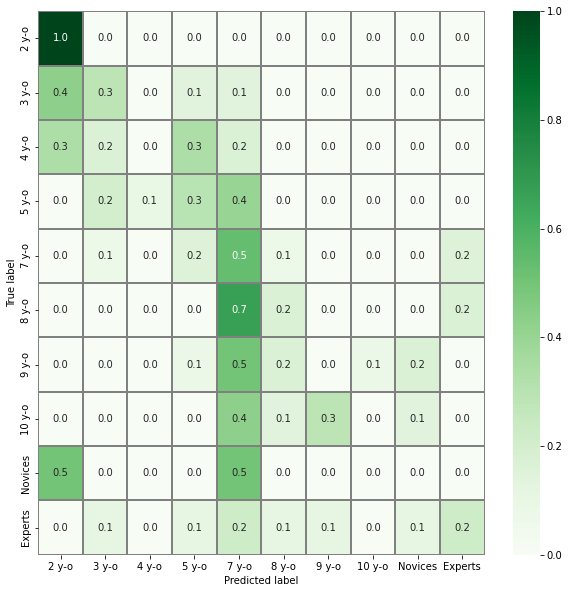

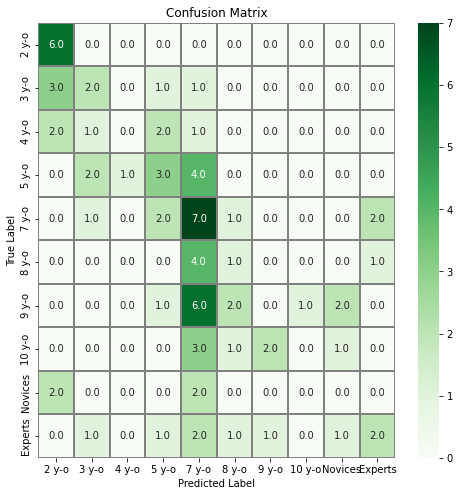

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(labels, predictions)

cmn = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
labels_ticks = ['2 y-o','3 y-o','4 y-o','5 y-o','7 y-o','8 y-o','9 y-o','10 y-o','Novices','Experts']
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f')
ax.set_xticklabels(labels_ticks)
ax.set_yticklabels(labels_ticks)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('../figures_papier/mat_conf_10_classes_prop.png', dpi = 700)
plt.show(block=False)

labels_ticks = ['2 y-o','3 y-o','4 y-o','5 y-o','7 y-o','8 y-o','9 y-o','10 y-o','Novices','Experts']

ax.set_xticklabels(labels_ticks)





# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
ax.set_xticklabels(labels_ticks)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
ax.set_xticklabels(labels_ticks)
ax.set_yticklabels(labels_ticks)
plt.savefig('../figures_papier/mat_conf_10_classes.png', dpi = 700)
plt.show()